## **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


## **Importing Libraries**

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense, Conv1D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

import itertools 

In [3]:
train_path = "/content/drive/MyDrive/Project/Data/Spectrograms/train"
test_path = "/content/drive/MyDrive/Project/Data/Spectrograms/test"
class_mode = 'categorical'
color_mode = 'rgb'
shuffle = True
batch_size=32

## **Generating train and test data**

In [4]:
traindata = ImageDataGenerator().flow_from_directory(directory=train_path, target_size= (224,224),batch_size=batch_size,class_mode=class_mode,
                                                             color_mode=color_mode, shuffle=shuffle)
testdata = ImageDataGenerator().flow_from_directory(directory=test_path, target_size= (224,224),batch_size=batch_size, class_mode=class_mode,
                                                             color_mode=color_mode, shuffle=False)

Found 1202 images belonging to 16 classes.
Found 298 images belonging to 16 classes.


## **Fitting the data to VGG16 model and Training**

In [5]:
input_shape = Input(shape=(224, 224, 3))
model_vgg16 = VGG16(weights=None,include_top=False ,input_tensor=input_shape, classes=16)
model_output = model_vgg16(input_shape)

vgg = Flatten(name='flatten')(model_output)
vgg = Dense(4096, activation='relu', name='fc1')(vgg)
vgg = Dense(4096, activation='relu', name='fc2')(vgg)
vgg = Dropout(0.5)(vgg)
vgg = Dense(16, activation='softmax', name='predictions')(vgg)

model = Model(inputs=input_shape, outputs=vgg)

optimizer = keras.optimizers.SGD(lr = 0.001, momentum=0.9, decay=0.0)

In [6]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Project/Model/VGG16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, 
                              save_weights_only=False, mode='auto', period=1)

## Early stopping is used to avoid model overfitting. 
##If the model accuracy on validation set does not increase in 20 consecutive iterations the model will stop training further.
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [8]:
hist = model.fit_generator(generator=traindata, validation_data=testdata, epochs=30,
                                                 callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
38/38 [==============================] - 359s 8s/step - loss: 2.7969 - accuracy: 0.0617 - val_loss: 2.7381 - val_accuracy: 0.0772

Epoch 00001: val_accuracy improved from -inf to 0.07718, saving model to /content/drive/MyDrive/Project/Model/VGG16.h5
Epoch 2/30
38/38 [==============================] - 19s 491ms/step - loss: 2.7302 - accuracy: 0.1086 - val_loss: 2.7013 - val_accuracy: 0.1678

Epoch 00002: val_accuracy improved from 0.07718 to 0.16779, saving model to /content/drive/MyDrive/Project/Model/VGG16.h5
Epoch 3/30
38/38 [==============================] - 19s 486ms/step - loss: 2.6748 - accuracy: 0.1397 - val_loss: 2.5628 - val_accuracy: 0.0705

Epoch 00003: val_accuracy did not improve from 0.16779
Epoch 4/30
38/38 [==============================] - 18s 475ms/step - loss: 2.5299 - accuracy: 0.1588 - val_loss: 2.4647 - val_accuracy: 0.2819

Epoch 00004: val_accuracy improved from 0.16779 to 0.28188, saving model to /content/drive/MyDrive/Project/Model/VGG16.h5
Epoch 5/

## **Plotting accuracy and loss plots**

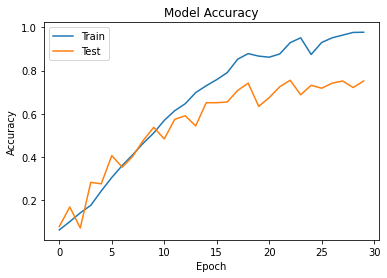

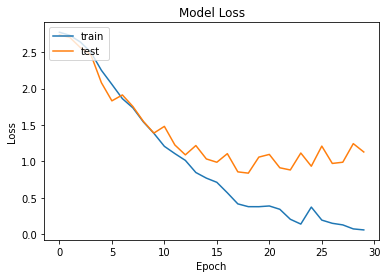

In [9]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_Accuracy.png')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

## **Predicting on test data**

In [20]:
Y_pred = model.predict_generator(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('tuned_confusion_matrix.jpg')
    plt.show()

In [17]:
target_names = []

for key in traindata.class_indices:

    target_names.append(key)

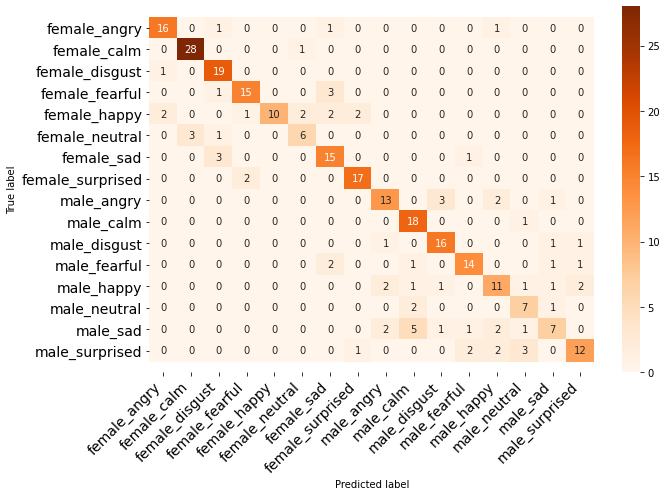

In [18]:
print_confusion_matrix(cm, target_names)

## **male_sad id more often predicted as male_calm**

In [19]:
print(classification_report(testdata.classes, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

    female_angry       0.84      0.84      0.84        19
     female_calm       0.90      0.97      0.93        29
  female_disgust       0.76      0.95      0.84        20
  female_fearful       0.83      0.79      0.81        19
    female_happy       1.00      0.53      0.69        19
  female_neutral       0.67      0.60      0.63        10
      female_sad       0.65      0.79      0.71        19
female_surprised       0.85      0.89      0.87        19
      male_angry       0.72      0.68      0.70        19
       male_calm       0.67      0.95      0.78        19
    male_disgust       0.76      0.84      0.80        19
    male_fearful       0.78      0.74      0.76        19
      male_happy       0.61      0.58      0.59        19
    male_neutral       0.54      0.70      0.61        10
        male_sad       0.58      0.37      0.45        19
  male_surprised       0.75      0.60      0.67        20

        accu

## **From classification report we can see VGG16 is able to acheive an accuracy of 75%.**
## **Based on F1-score, model did a poor job on predicting male_sad and better job on predicting female_calm**